In [84]:
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd 
from modules import preprocessing as pp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data import

#### Define the study crop and country

In [228]:
# USER INPUTS
ecmwf_country = "US" # one of ["US", "BR"]
crop = "wheat" # one of ["maize", "wheat"]

shapefile_path = ""
if ecmwf_country == "US":
    shapefile_path = '../data/shapefiles/US/tl_2023_us_county/tl_2023_us_county.shp'
elif ecmwf_country == "BR":
    shapefile_path = '../data/shapefiles/BR/bra_admbnda_adm2_ibge_2020.shp'

#### Read Data

<Axes: >

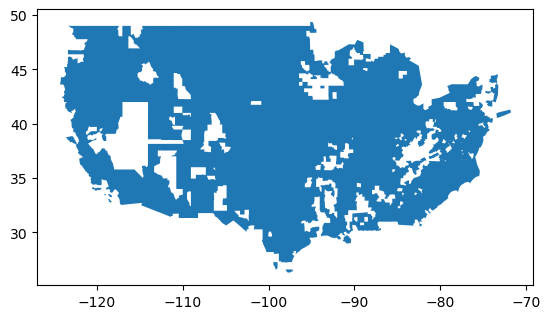

In [149]:
# CY-BENCH
yield_data = pd.read_csv("../data/CY-Bench/{}/{}/yield_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
era = pd.read_csv("../data/CY-Bench/{}/{}/meteo_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
relevant_adm_ids = yield_data["adm_id"].unique()
era = era.loc[era["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)

# Stella: 8-day time steps
start_dates = pd.read_csv("../data/annual_eight_day_bins.csv")
start_dates = start_dates.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))
day_of_year_to_time_step = start_dates.iloc[:, 0].dt.day_of_year.reset_index().set_index(start_dates.columns[0])["index"].to_dict()

# Country shapefile
country_gpd = gpd.read_file(shapefile_path, crs="EPSG:4326")
country_gpd["adm_id"] = "{}-".format(ecmwf_country) + country_gpd["STATEFP"].astype(str) + "-" + country_gpd["COUNTYFP"].astype(str)
mismatches = [adm_id for adm_id in yield_data["adm_id"].unique() if adm_id not in country_gpd["adm_id"].unique()]
country_gpd = country_gpd.loc[country_gpd["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)
if ecmwf_country == "US":
    country_gpd_shape = country_gpd.dissolve().to_crs("EPSG:4326")
else:
    country_gpd_shape = country_gpd.dissolve().set_crs("EPSG:4326")

country_gpd_shape.plot()

#### Resample ERA to match 8-day bins

In [91]:
era["date"] = pd.to_datetime(era["date"], format="%Y%m%d")
era = era[["adm_id", "date", "tmin", "tmax", "prec", "tavg"]]

li = []
for year in era.date.dt.year.unique():
    era_year = era.loc[era["date"].dt.year == year]
    era_year_resampled = (era_year
                                    .groupby(["adm_id"]).resample("8D", on="date")[["tmin", "tmax", "prec", "tavg"]].mean()
                                    .reset_index()
                                    .rename(columns={"date":"start_date_bin"})
                                )
    li.append(era_year_resampled)

era_resampled = pd.concat(li)
era_resampled = era_resampled.assign(time_step=era_resampled["start_date_bin"].apply(lambda x: day_of_year_to_time_step[x.day_of_year]))
era_resampled.sample(3)

,adm_id,start_date_bin,tmin,tmax,prec,tavg,time_step
88343,US-47-045,2010-07-04,23.595187,32.835101,1.048405,28.164098,23
71531,US-39-015,2020-01-09,2.449296,12.640375,5.980282,7.506240,1
22051,US-17-191,2008-05-16,10.745964,22.129603,0.976446,16.824879,17


## 2. Bring ERA and ECMWF together

Seasonal climate forecasts (SCM) from ECMWF are initialized at the first of each month from January to December. The forecasts are provided for 7 months ahead. Regardless of the crop calendar definition, in-season yield forecasts will be validated throughout the season each time a new ECMWF forecasts is available at the beginning of each month. Below is an illustration of how ERA and SCM data will be concatenated depending on the month of initialization. Furthermore, since forecast length is up to 7 month, in-season yield forecast validation will start earliest 7 month before harvest. All past months will be consecutively supplemented wit AgERA5 data from CY-Bench each month as harvest is approached. See example cropping season from April to October (dashed line) in the image below. Once this logic is implemented, crop calendars of arbitrary length (max. 7 month) can be extracted from the data and used to build the feature vector. 


![title](../figures/overview_era_scm_init_month.png)

In [255]:
li = []
for ecmwf_init_month in ["jan", "feb", "mar", "apr", "may", "june", "july", "aug", "sep", "oct", "nov", "dec"]:
    ################# ECMWF #################
    ecmwf = pd.read_csv("../data/ECMWF/{}/ecmwf_csv/ecmwf_{}.csv".format(ecmwf_country, ecmwf_init_month)).rename(columns={"t2m":"tavg", "tp":"prec", "mx2t24":"tmax", "mn2t24":"tmin"})
    ecmwf[["tavg", "tmax", "tmin"]] = ecmwf[["tavg", "tmax", "tmin"]] - 273.15 # Convert to Celsius
    ecmwf["valid_time"] = pd.to_datetime(ecmwf["valid_time"])
    ecmwf["time"] = pd.to_datetime(ecmwf["time"])
    ecmwf["prec"] = ( # disaggregate precipitation and convert to mm
        ecmwf.sort_values(["latitude", "longitude", "time", "valid_time"]).reset_index(drop=True)
        .groupby(["time", "latitude", "longitude"])["prec"].transform(lambda x: x.diff().fillna(x).clip(lower=0) * 1000)
    )

    ecmwf_resampled = pp.resample_ecmwf(ecmwf, start_dates) # Resample ECWMF to match 8-day bins

    counties_with_ecmwf_data = pp.assign_ecmwf_forecasts_to_counties(ecmwf_resampled, country_gpd, start_dates, "adm_id") # assign counties to ECMWF grid cells

    if ecmwf_init_month != "jan":
        ################# ERA #################
        era_filtered = era_resampled.loc[(era_resampled["start_date_bin"].dt.day_of_year < ecmwf_resampled["start_date_bin"].dt.day_of_year.min())].reset_index(drop=True)
        era_pivot = (era_filtered.assign(init_date = pd.to_datetime(era_filtered["start_date_bin"].dt.year.astype(str) + "-" + counties_with_ecmwf_data["init_date"].dt.month.unique()[0].astype(str) + "-" + counties_with_ecmwf_data["init_date"].dt.day.unique()[0].astype(str)))
                    .pivot(index=["adm_id", "init_date"], columns="time_step", values=["tavg", "tmin", "tmax", "prec"]))
        era_pivot.columns = ["_".join([str(col) for col in c]).strip() for c in era_pivot.columns]
        era_pivot = era_pivot.reset_index()

        ################# MERGE ERA AND ECMWF #################
        era_ecmwf = counties_with_ecmwf_data.merge(era_pivot, on=["adm_id", "init_date"], how="left")
        era_ecmwf = era_ecmwf.assign(year=era_ecmwf["init_date"].dt.year, init_month=era_ecmwf["init_date"].dt.month, init_time_step=day_of_year_to_time_step[ecmwf_resampled["start_date_bin"].dt.day_of_year.min()]).set_index(["adm_id", "year", "init_month", "init_time_step"]).drop("init_date", axis=1)

        li.append(era_ecmwf)
    else:
        era_ecmwf = counties_with_ecmwf_data.assign(year=counties_with_ecmwf_data["init_date"].dt.year, init_month=counties_with_ecmwf_data["init_date"].dt.month, init_time_step=0).set_index(["adm_id", "year", "init_month", "init_time_step"]).drop("init_date", axis=1)
        li.append(era_ecmwf)


In [262]:
pd.concat(li).to_csv("../data/ecmwf_era.csv")